# Codigo Ejemplo

In [268]:
#-------------------------------------------------------------------------------------
# AVISO: este codigo esta adaptado de un paquete mayor. 
# No es optimo y tiene cosas inutiles para nosotros. Es un ejemplo nada mas
#
#general forward greedy selection function
#input:
# x,y inputs and targets
# method is an external function that estimates classification error with a given model
# ... parameters for method
#output:
#ordered.names.list <- nombre de las variables ordenadas de la mas importante a la menos
#ordered.features.list <-numero de orden inicial de las variables, con el mismo orden
#importance <- importancia de cada variables en el mismo orden

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]
	num.feat<-1
	list.feat<-1:max.feat

	#ranking inicial: elijo la variable con menor error de prediccion
  x.train<-matrix(0,dim(x)[1],1)
	class.error<-double(max.feat)
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train[,1]<-x[,i]
		class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) )
	}
	#guardo la variable con minimo error como primera. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]
	#armo un dataset con las variables que ya elegi, para ir agregando en cada paso.
	x.prev<-x.train[,1]<-x[,list.feat[1]]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego al dataset del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			x.train<-cbind(x.prev,x[,keep.feat[i]])
			class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan, y actualizo el dataset de partida de la iteracion.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1
		x.prev<-x[,list.feat[1:num.feat]]
	}


	search.names<-colnames(x)[list.feat]
	#le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos
	imp<-(max.feat:1)/max.feat
	names(imp)<-search.names

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )
}


#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	
	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#filter con kruskal esta en las slides


library(randomForest)
library(kernlab)
library(MASS)

#demo: aplicar el wrapper a los datos de iris
data(iris)
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est")


#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar

crea.ruido.unif<-function(n=100,d=2){
x<-runif(2*n*d,min=-1)	#genero los datos
dim(x)<-c(2*n,d)
return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

#datosA
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

#datosB
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos

In [206]:
backward.ranking = function(x, y, method, ...) {
  max.feat = dim(x)[2]
	list.feat = 1:max.feat
  keep.feat = double(max.feat)

  while(length(list.feat) > 1){
		class.error = double(length(list.feat))

		# Para cada feature, entreno el modelo y le mido el error.
		for(i in 1:length(list.feat)){
			x.train = as.matrix(x[, list.feat[-i]])
			class.error[i] = do.call(method, c(list(x.train, y), list(...)) )
		}

		# Seleccionar el peor feature y lo saco de la lista.
		worst.feat = which.min(class.error)
		keep.feat[length(list.feat)] = list.feat[worst.feat]
		list.feat = list.feat[-worst.feat]
  }

	keep.feat[1] = list.feat

	search.names = colnames(x)[keep.feat]
	# Le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos.
	imp = (max.feat:1)/max.feat
	names(imp) = search.names

 	return( list(ordered.names.list=search.names,ordered.features.list=keep.feat,importance=imp) )
}

In [207]:
kruskal_wallis.ranking = function(x, y) {
  max.feat = dim(x)[2]
  rank.list = c()

  # Para cada feature, calculo su estadistico de kruskal wallis.
  for (i in 1:max.feat) rank.list[i] = kruskal.test(x[,i],y)$statistic

  # Ordeno los features por su estadistico de kruskal wallis.
  rank.list = sort(rank.list, decreasing=TRUE, index.return=TRUE)$ix

  search.names = colnames(x)[rank.list]
	# Le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos.
	imp = (max.feat:1)/max.feat
	names(imp) = search.names

  return( list(ordered.names.list=search.names,ordered.features.list=rank.list,importance=imp) )
}

In [275]:
rfe.ranking = function(x, y, method, ...) {
  max.feat = dim(x)[2]
  rank.list = 1:max.feat
  list.feat = 1:max.feat

  for (i in 1:max.feat) {
    x.train = as.matrix(x[,list.feat])
    rank_ = do.call(method, c(list(x.train, y), list(...)) )
    last = rank_$feats[1]
    rank.list[max.feat - i + 1] = list.feat[last]
    list.feat = list.feat[-last]
  }

  search.names = colnames(x)[rank.list]
	# Le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos.
	imp = (max.feat:1)/max.feat
	names(imp) = search.names

  return( list(ordered.names.list=search.names,ordered.features.list=rank.list,importance=imp) )
}

# Ejercicio 2

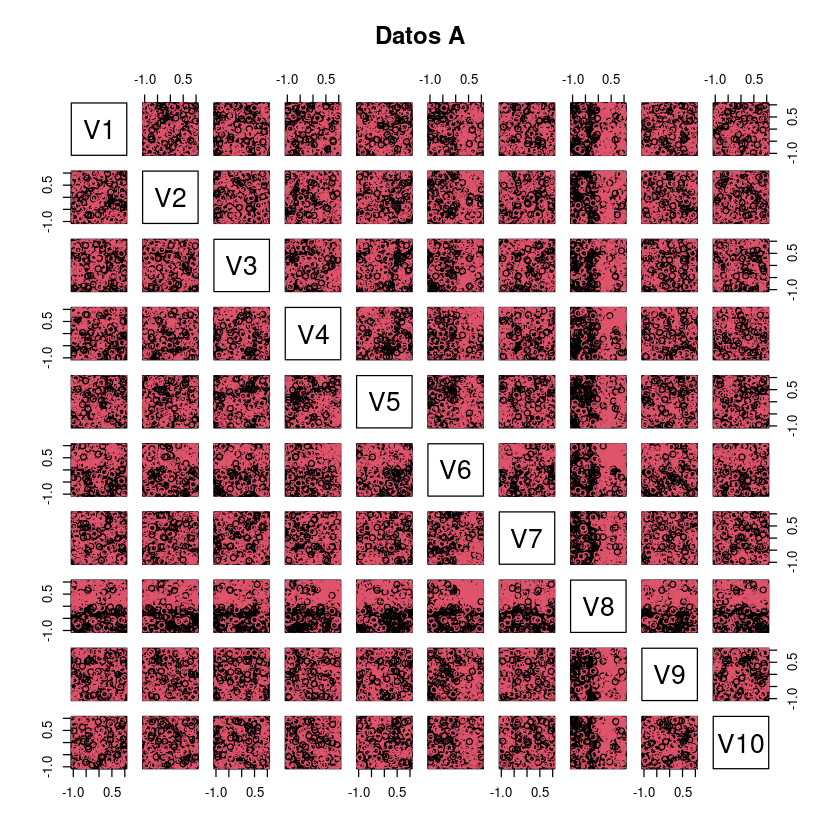

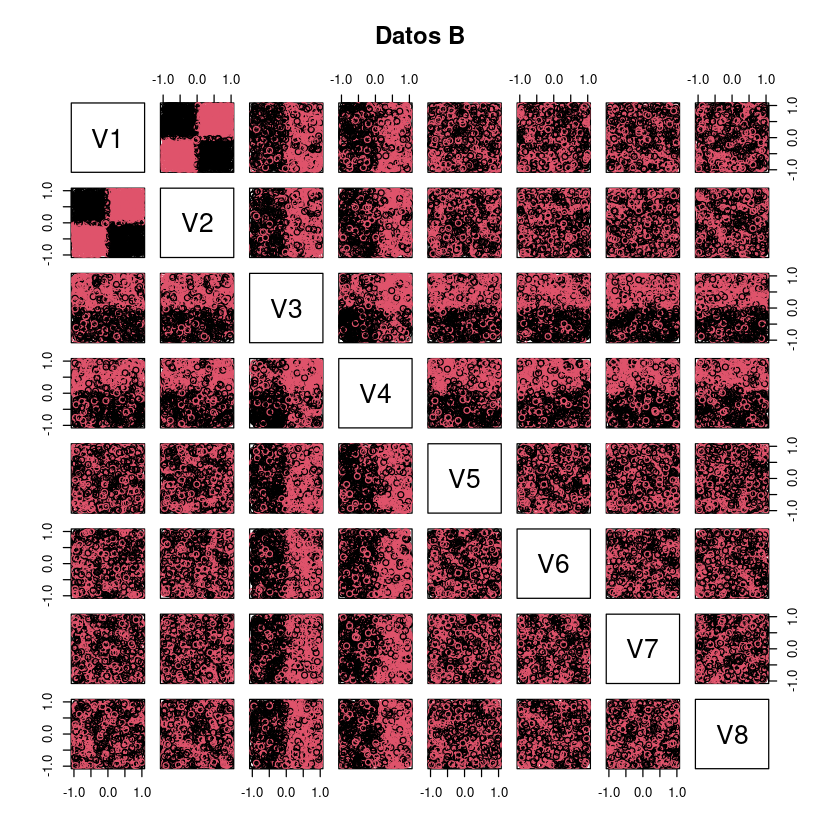

In [269]:
datosA.x = datosA[,1:10]
datosA.y = datosA$y
datosB.x = datosB[,1:8]
datosB.y = datosB$y

plot(datosA.x, col=datosA.y, main="Datos A")
plot(datosB.x, col=datosB.y, main="Datos B")

## Datos A
Podemos ver que con los datos A, la feature que mas clasifica a las 2 clases es la V8, ya que si se relaciona con las otras variables, se puede ver una muy buena separacion de las clases.

Con esto podemos decir que en casi todos los metodos, la variable con mejor rank va a ser la V8.

## Datos B
En este caso, se puede ver claramente como las features V1 y V2 juntas son las que mejor clasifica a los datos, y ya podemos suponer que con el metodo backward, estas dos variables van a ser las que mejor rank tengan. (Se puede notar como estan relacionadas estas 2 variables).

Por otro lado, se puede ver como V3 y V4 genera una separacion de las clases (pero no tan buena como la hacen V1 y V2 juntas).

In [249]:
sort_info = function(list) {
  ord.names = c()
  ord.values = c()

  i = 1
  for (j in list$ordered.features.list) {
    ord.names[j] = list$ordered.names.list[i]
    ord.values[j] = list$importance[i]
    i = i + 1
  }

  return ( list(names=ord.names, values=ord.values) )
}

plotbar_values = function(list, title) {
  ord.info = sort_info(list)
  barplot(ord.info$values, names.arg=ord.info$names, main=title, las=2, col="cyan") 
}

# Datos A

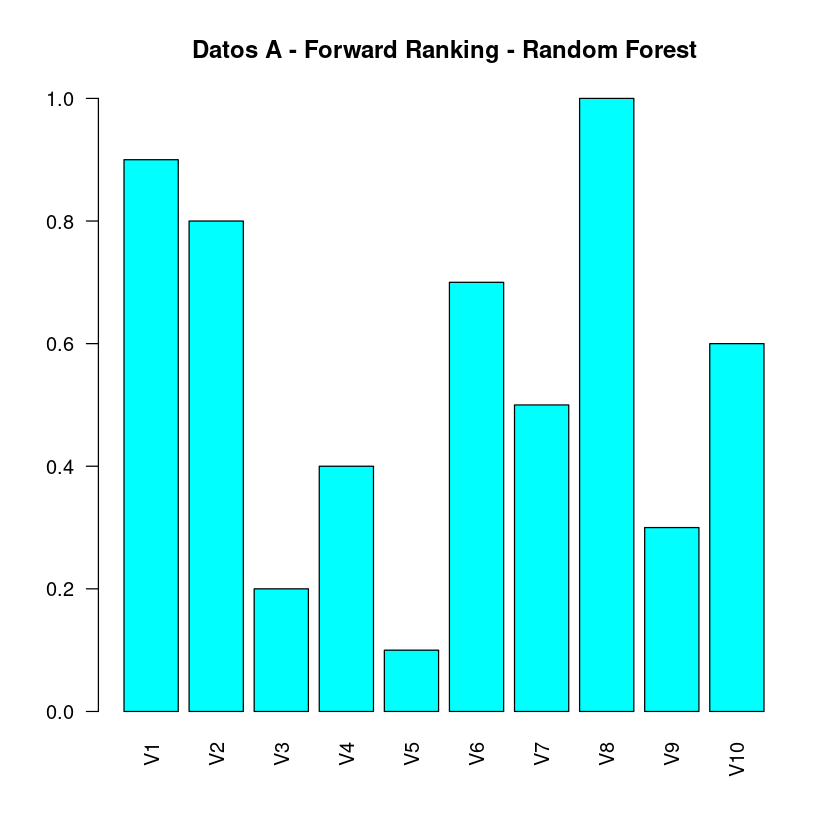

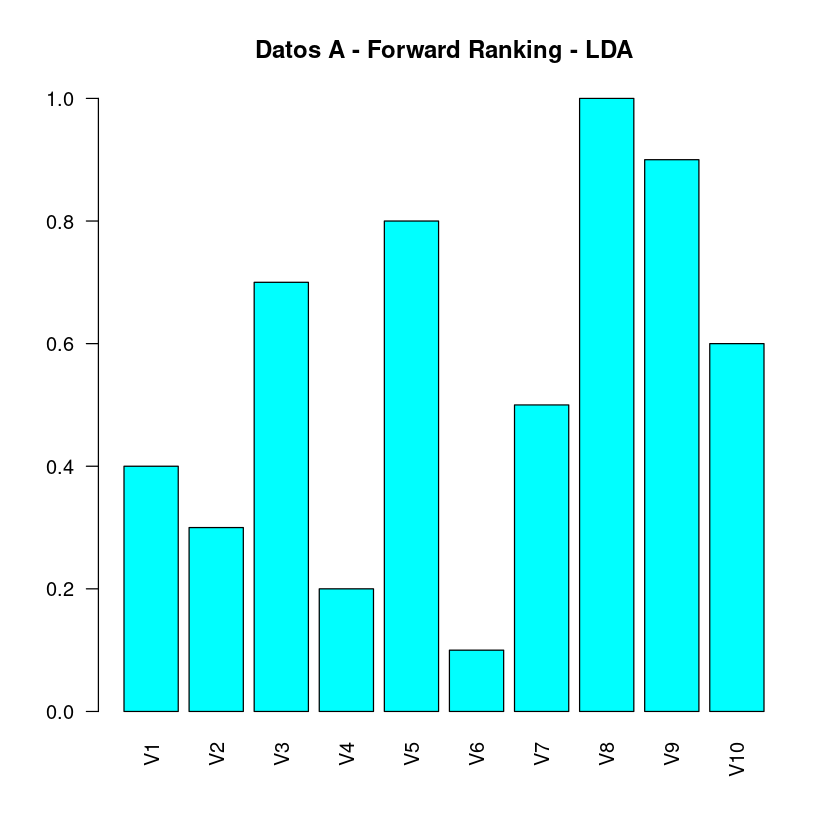

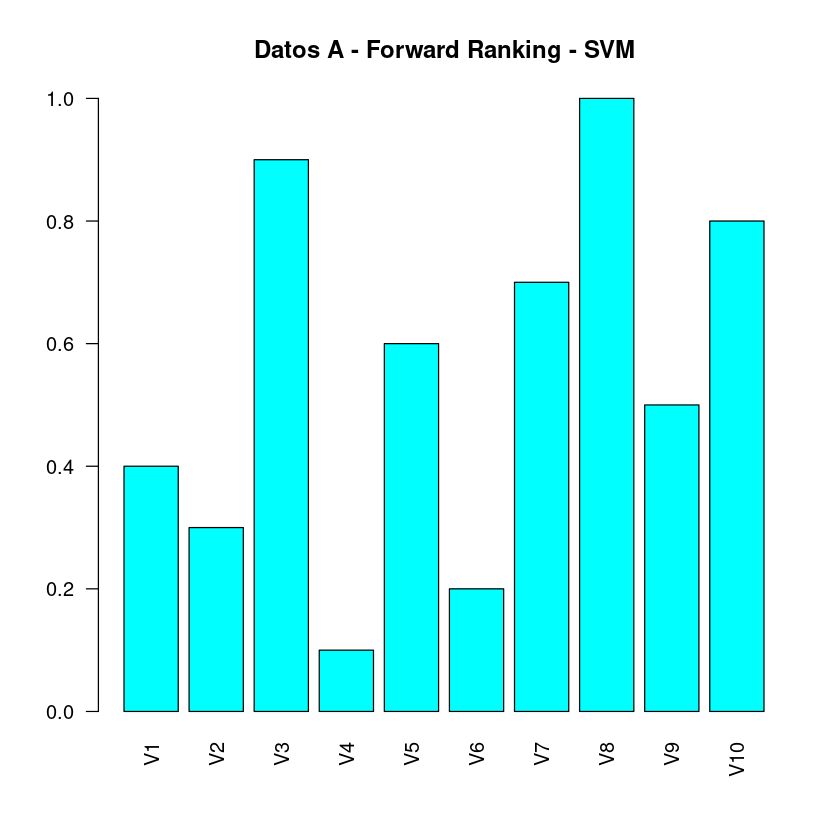

In [122]:
datosA.fr.rf = forward.ranking(datosA.x, datosA.y, "rf.est")
datosA.fr.lda = forward.ranking(datosA.x, datosA.y, "lda.est")
invisible(capture.output(datosA.fr.svm <- forward.ranking(datosA.x, datosA.y, method="svm.est")))

plotbar_values(datosA.fr.rf, "Datos A - Forward Ranking - Random Forest")
plotbar_values(datosA.fr.lda, "Datos A - Forward Ranking - LDA")
plotbar_values(datosA.fr.svm, "Datos A - Forward Ranking - SVM")

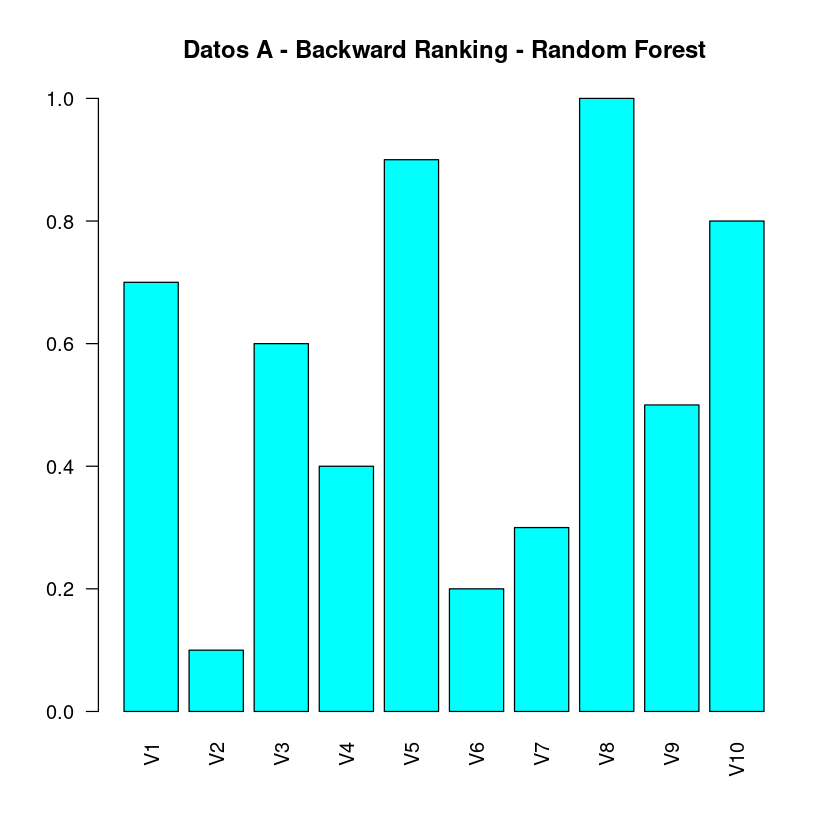

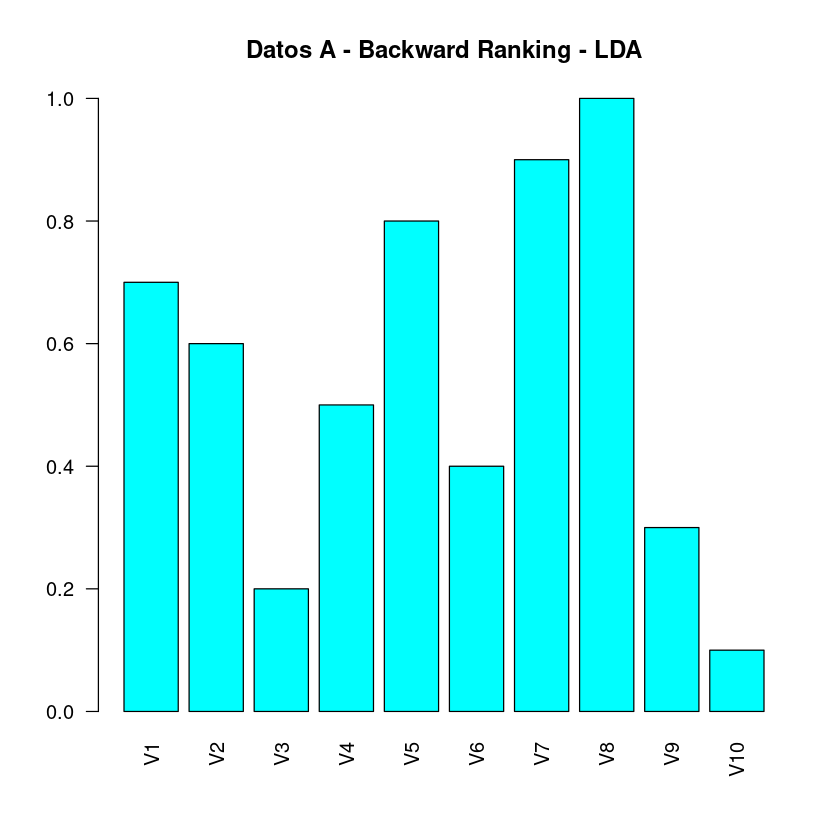

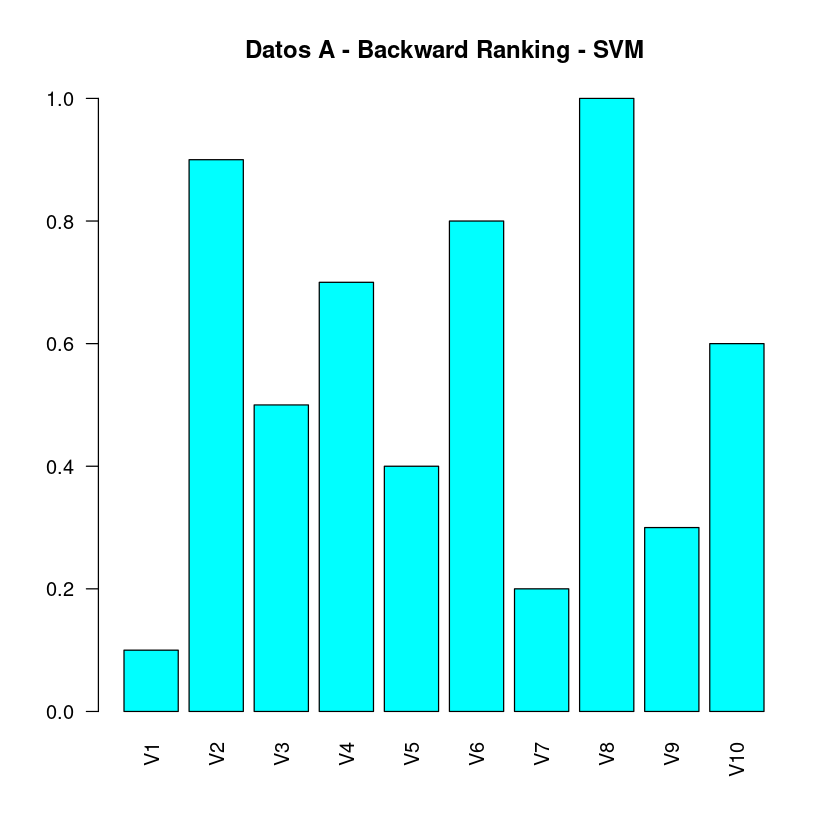

In [123]:
datosA.br.rf = backward.ranking(datosA.x, datosA.y, "rf.est")
datosA.br.lda = backward.ranking(datosA.x, datosA.y, "lda.est")
invisible(capture.output(datosA.br.svm <- backward.ranking(datosA.x, datosA.y, method="svm.est")))

plotbar_values(datosA.br.rf, "Datos A - Backward Ranking - Random Forest")
plotbar_values(datosA.br.lda, "Datos A - Backward Ranking - LDA")
plotbar_values(datosA.br.svm, "Datos A - Backward Ranking - SVM")

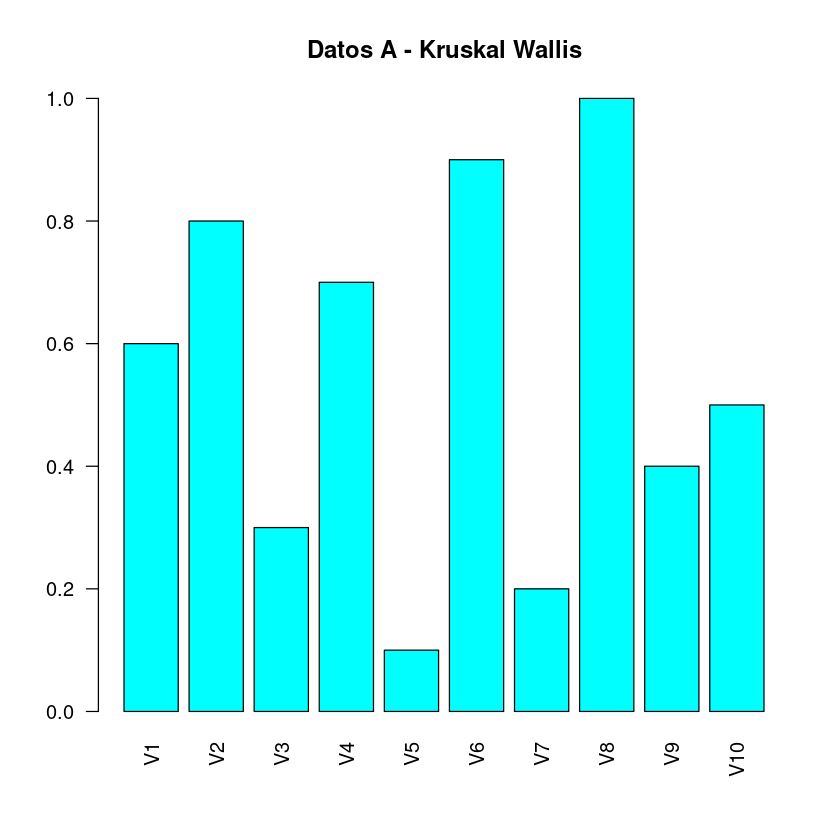

In [139]:
datosA.kw = kruskal_wallis.ranking(datosA.x, datosA.y)
plotbar_values(datosA.kw, "Datos A - Kruskal Wallis")

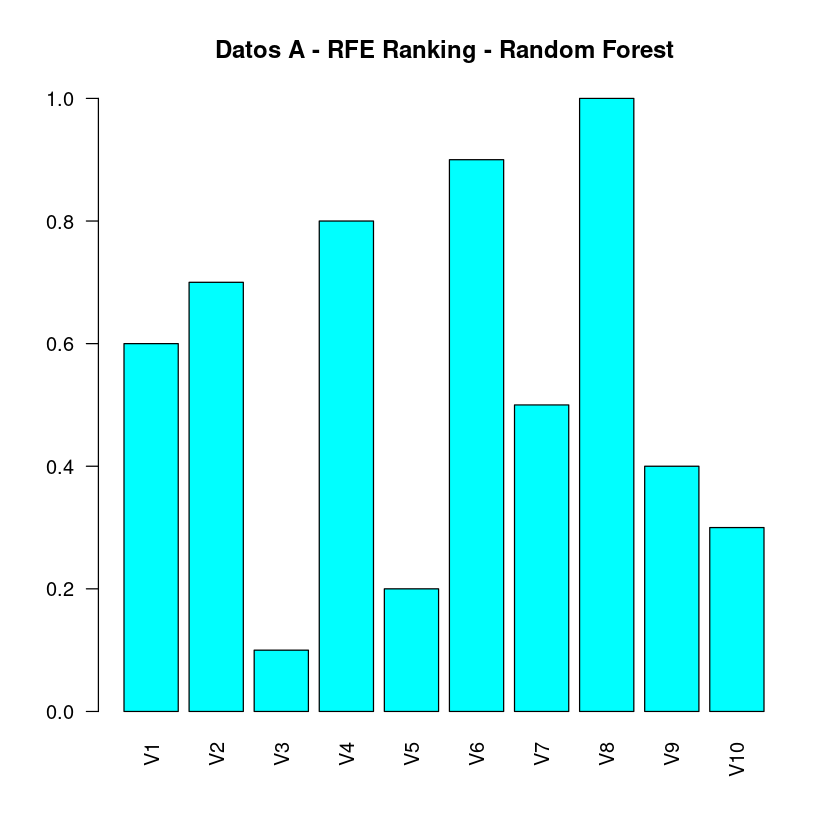

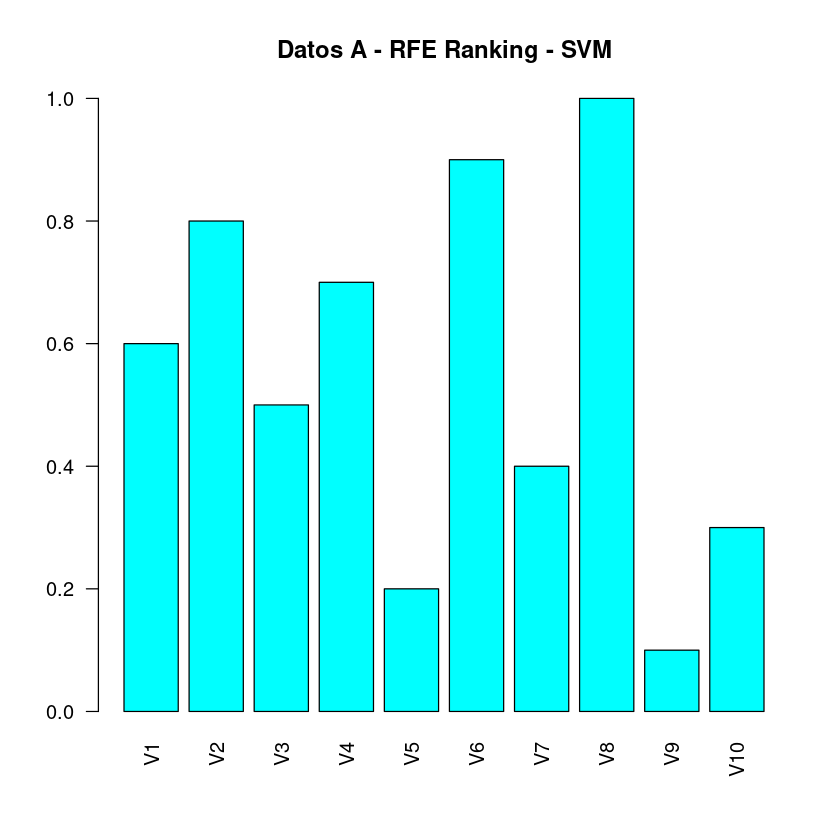

In [125]:
datosA.rr.rf = rfe.ranking(datosA.x, datosA.y, "imp.rf")
invisible(capture.output(datosA.rr.svm <- rfe.ranking(datosA.x, datosA.y, method="imp.linsvm")))

datosA.rr.rf$importance = datosA.rr.rf$imp
datosA.rr.svm$importance = datosA.rr.svm$imp

plotbar_values(datosA.rr.rf, "Datos A - RFE Ranking - Random Forest")
plotbar_values(datosA.rr.svm, "Datos A - RFE Ranking - SVM")

Como comentamos al principio, suponiamos que el feature V8 era el que iba a tener mejor rank ya que era la variable que separaba mejor las clases. Se puede ver que con todos los metodos, esta feature (V8) fue la que mejor rank tuvo.

# Datos B

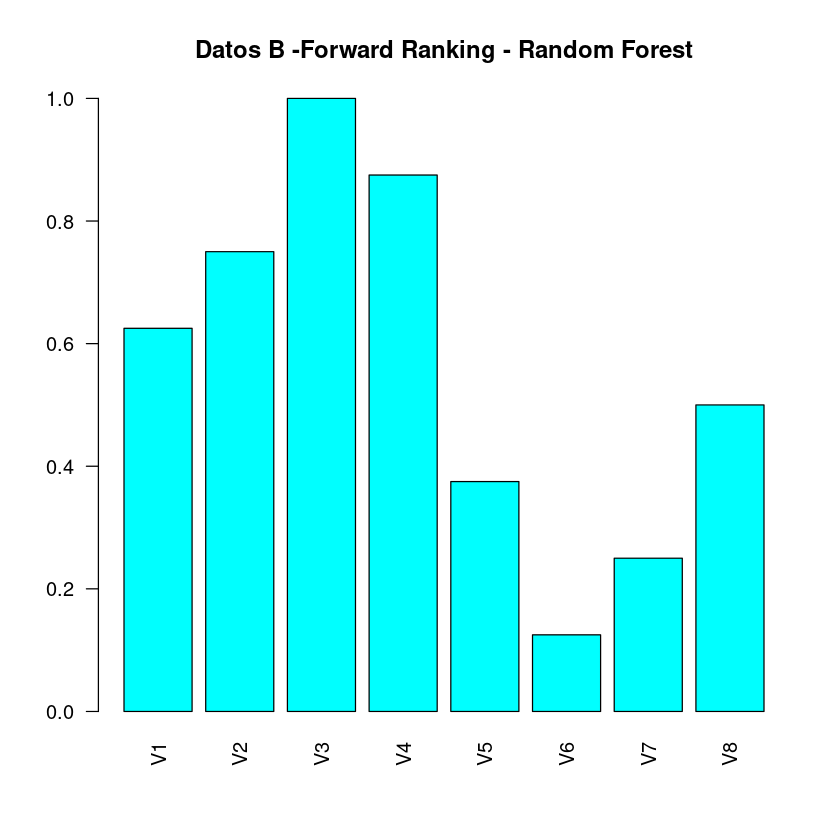

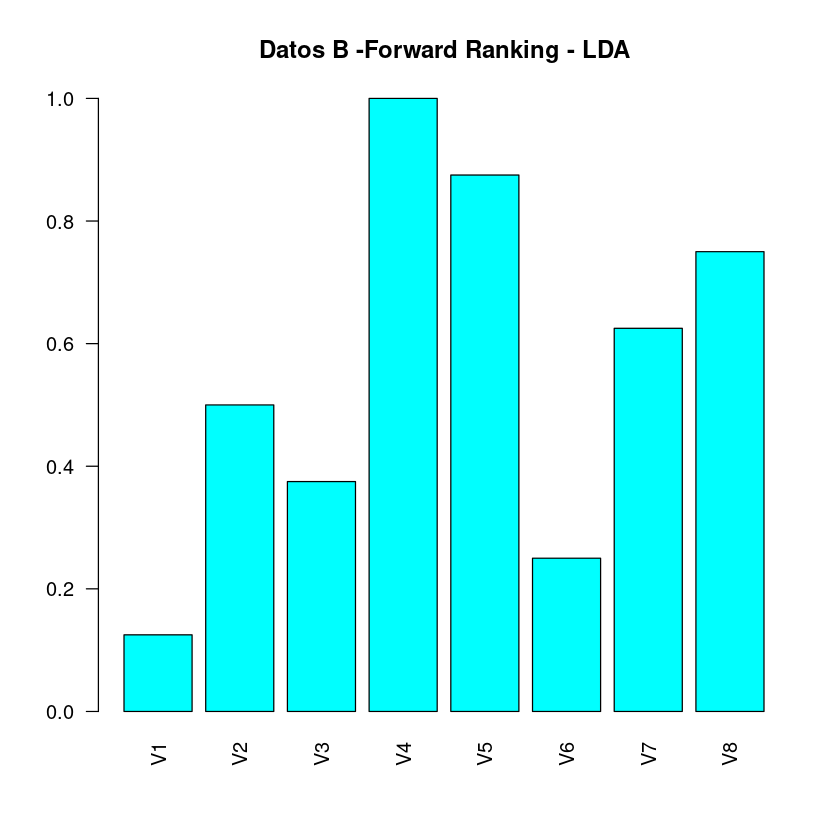

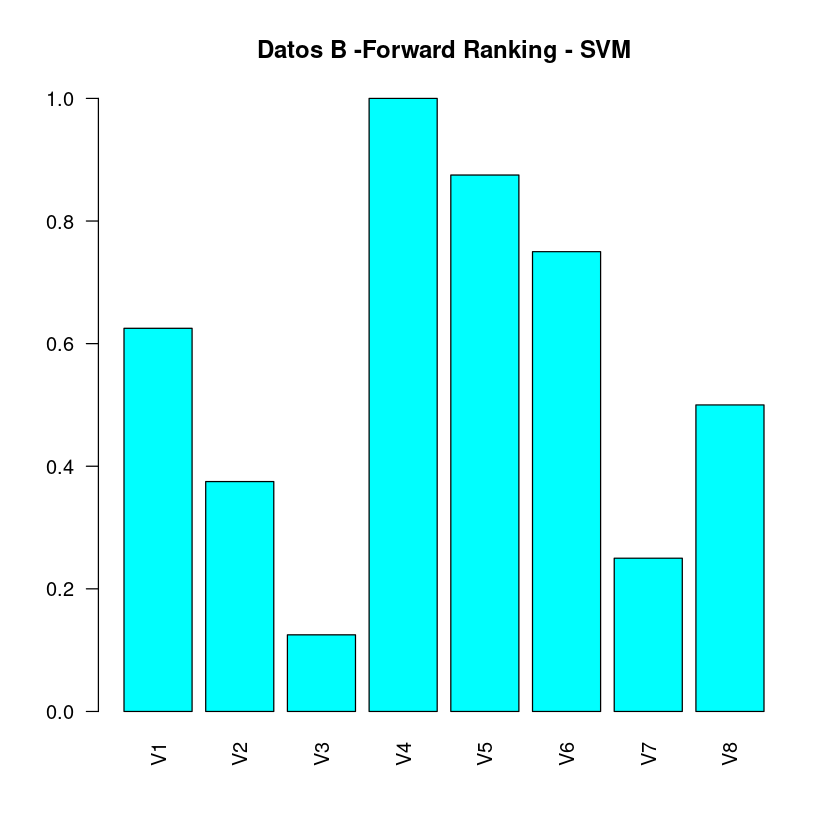

In [126]:
datosB.fr.rf = forward.ranking(datosB.x, datosB.y, "rf.est")
datosB.fr.lda = forward.ranking(datosB.x, datosB.y, "lda.est")
invisible(capture.output(datosB.fr.svm <- forward.ranking(datosB.x, datosB.y, method="svm.est")))

plotbar_values(datosB.fr.rf, "Datos B -Forward Ranking - Random Forest")
plotbar_values(datosB.fr.lda, "Datos B -Forward Ranking - LDA")
plotbar_values(datosB.fr.svm, "Datos B -Forward Ranking - SVM")

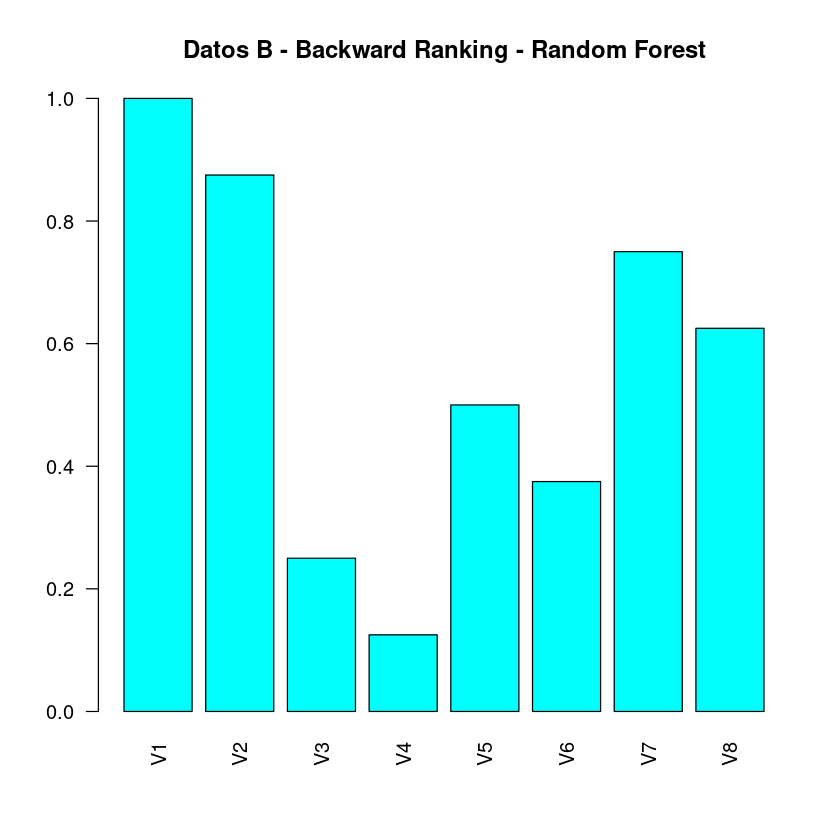

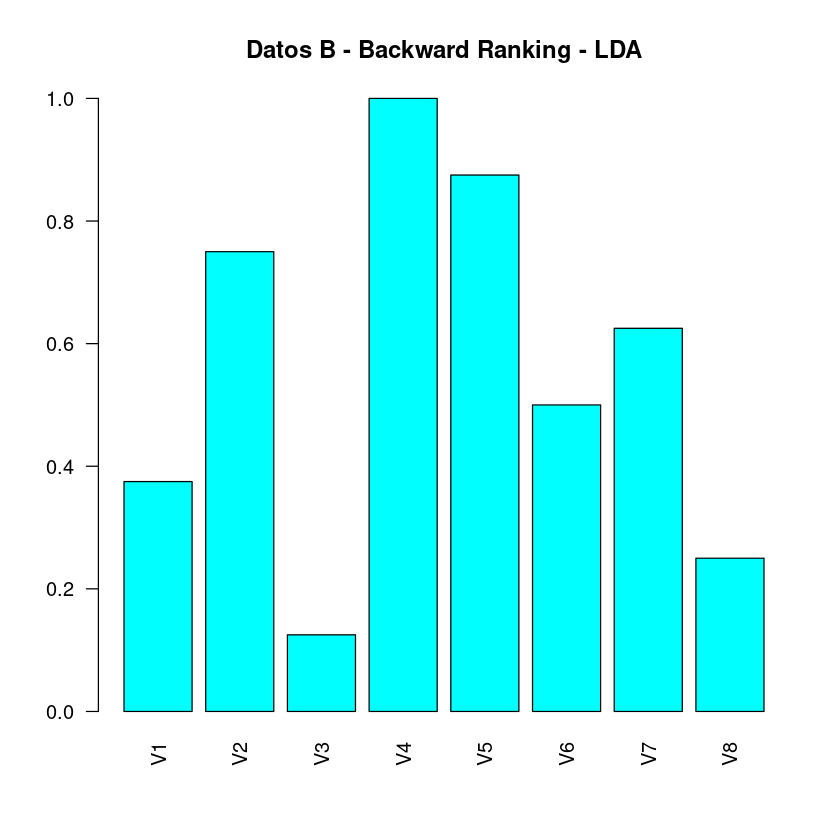

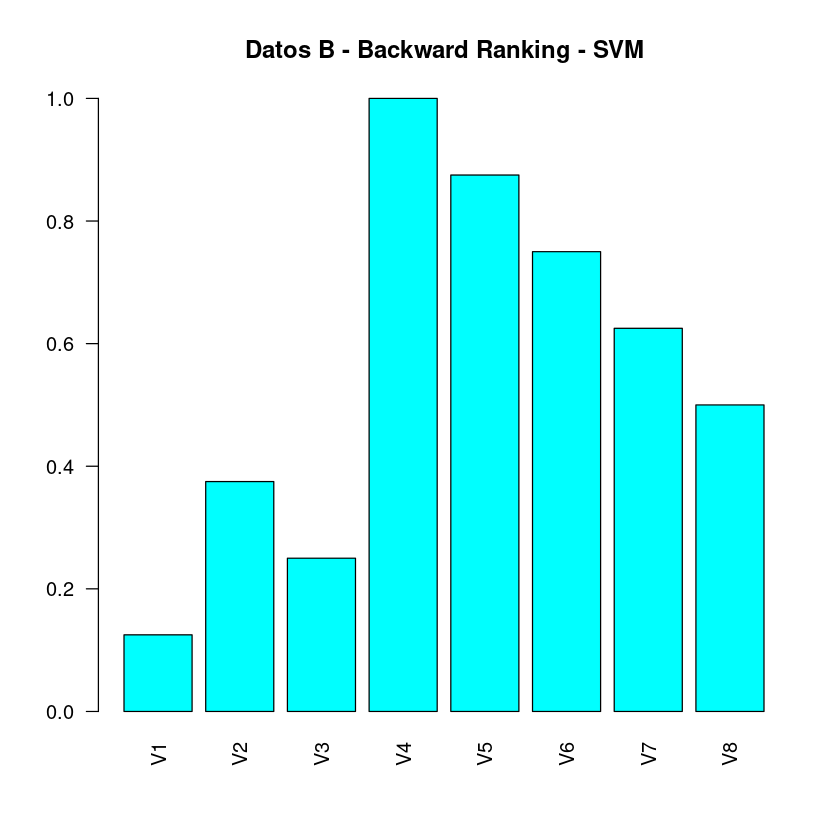

In [127]:
datosB.br.rf = backward.ranking(datosB.x, datosB.y, "rf.est")
datosB.br.lda = backward.ranking(datosB.x, datosB.y, "lda.est")
invisible(capture.output(datosB.br.svm <- backward.ranking(datosB.x, datosB.y, method="svm.est")))

plotbar_values(datosB.br.rf, "Datos B - Backward Ranking - Random Forest")
plotbar_values(datosB.br.lda, "Datos B - Backward Ranking - LDA")
plotbar_values(datosB.br.svm, "Datos B - Backward Ranking - SVM")

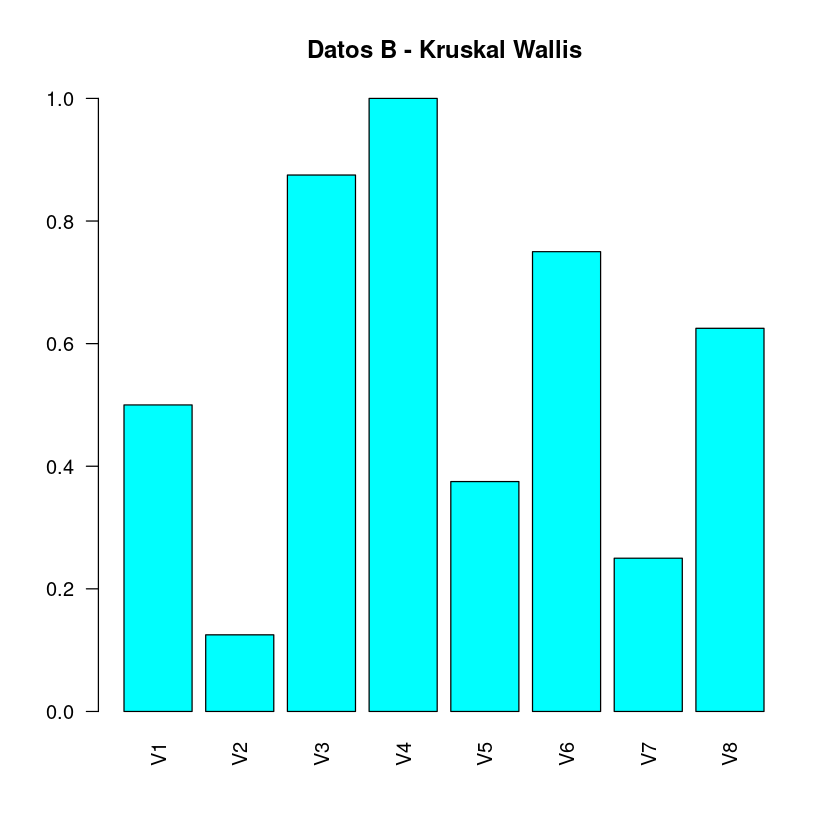

In [128]:
datosB.kw = kruskal_wallis.ranking(datosB.x, datosB.y)
plotbar_values(datosB.kw, "Datos B - Kruskal Wallis")

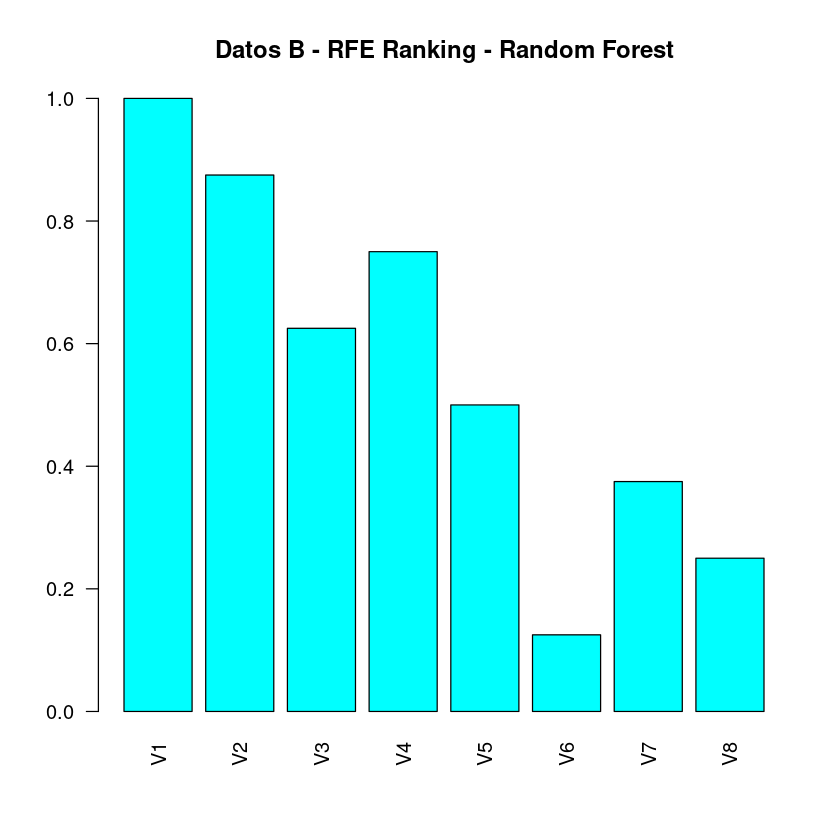

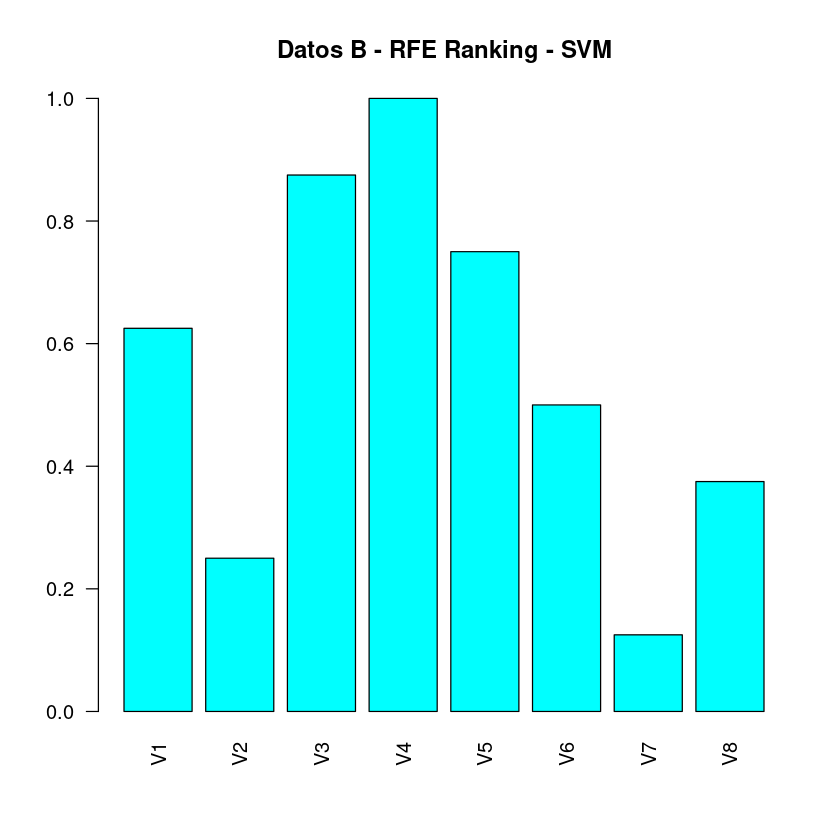

In [129]:
datosB.rr.rf = rfe.ranking(datosB.x, datosB.y, "imp.rf")
invisible(capture.output(datosB.rr.svm <- rfe.ranking(datosB.x, datosB.y, method="imp.linsvm")))

datosB.rr.rf$importance = datosB.rr.rf$imp
datosB.rr.svm$importance = datosB.rr.svm$imp

plotbar_values(datosB.rr.rf, "Datos B - RFE Ranking - Random Forest")
plotbar_values(datosB.rr.svm, "Datos B - RFE Ranking - SVM")

Con estos datos, no se cumplio mucho lo que comentamos al principio. Con el metodo backward, si se puede notar que le dio mejor rank a las variables V1 y V2, pero con el metodo forward, no se puede ver que le haya dado mejor rank a estas variables. Esto se puede deber a que el metodo backward se fija la relacion entre las features y de esta forma se da cuenta que con las variables V1 y V2 podemos clasificar perfectamente a los datos.

# Ejercicio 3

In [223]:
library(MASS)

create_points_diagonal = function(d, n, C) {
  center0 = rep(-1, d)
  center1 = rep(1, d)
  cov = diag(rep(C*sqrt(d)**2, d))
  mid = n / 2

  # Generamos random points
  class0_ = mvrnorm(mid, center0, cov)
  class1_ = mvrnorm(n-mid, center1, cov)

  
  class0 = cbind(class0_, rep(1, mid))
  class1 = cbind(class1_, rep(-1, n-mid))

  df = data.frame(rbind(class0, class1), row.names = NULL, check.rows = FALSE)
  colnames(df) = c(paste0("x", 1:d), "CLASS")

  return (df)
}

generar_df_ruido = function(df, d, n) {
  # Cantidad de columnas
  df.cols = ncol(df)
  cols = df.cols + d

  # Generamos ruido
  ruido = crea.ruido.unif(n=n, d=d)

  # Unimos los dos dataframes
  df.ruido.x = cbind(df[1:(df.cols-1)], ruido[1:d])

  df.ruido = cbind(df.ruido.x, df$CLASS)
  colnames(df.ruido) = c(paste0("V", 1:(cols-1)), "CLASS")
  df.ruido$CLASS = as.factor(df.ruido$CLASS)
  return (df.ruido)
}

data.diagonal = create_points_diagonal(10, 100, 2)
data.diagonal.ruido = generar_df_ruido(data.diagonal, 90, 100)

In [224]:
calcular_porcentaje = function(rank.list, names) {
  cnt = 0
  for (i in 1:10) if (names[i] %in% rank.list) cnt = cnt + 1
  
  return (cnt / 10)
}

In [225]:
porcentajes = c()
for (i in 1:30) {
  rank.list = kruskal_wallis.ranking(data.diagonal.ruido[,-101], data.diagonal.ruido$CLASS)
  rank.names.list = rank.list$ordered.names.list
  print(rank.names.list[1:10])


  porcentajes[i] = calcular_porcentaje(rank.names.list[1:10], colnames(data.diagonal.ruido)[1:10])
}

list(mean=mean(porcentajes), porcentajes=porcentajes)

 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V3"  "V2"  "V8"  "V5"  "V12" "V4"  "V79"
 [1] "V10" "V1"  "V6"  "V

$mean
[1] 0.8

$porcentajes
 [1] 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
[20] 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8

In [226]:
porcentajes = c()
for (i in 1:30) {
  rank.list = forward.ranking(data.diagonal.ruido[,-101], data.diagonal.ruido$CLASS, method="lda.est")
  rank.names.list = rank.list$ordered.names.list
  print(rank.names.list[1:10])


  porcentajes[i] = calcular_porcentaje(rank.names.list[1:10], colnames(data.diagonal.ruido)[1:10])
}

list(mean=mean(porcentajes), porcentajes=porcentajes)

 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V5"  "V53" "V19" "V63" "V91" "V21" "V24"
 [1] "V2"  "V6"  "V10" "V

$mean
[1] 0.4

$porcentajes
 [1] 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
[20] 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4

In [227]:
porcentajes = c()
for (i in 1:30) {
  rank.list = backward.ranking(data.diagonal.ruido[,-101], data.diagonal.ruido$CLASS, method="lda.est")
  rank.names.list = rank.list$ordered.names.list
  print(rank.names.list[1:10])


  porcentajes[i] = calcular_porcentaje(rank.names.list[1:10], colnames(data.diagonal.ruido)[1:10])
}

list(mean=mean(porcentajes), porcentajes=porcentajes)

 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10"  "V5"   "V8"   "V3"   "V60"  "V78"  "V46"  "V100"
 [1] "V6"   "V2"   "V10" 

$mean
[1] 0.6

$porcentajes
 [1] 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
[20] 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6

In [276]:
porcentajes = c()
for (i in 1:30) {
  rank.list = rfe.ranking(data.diagonal.ruido[,-101], data.diagonal.ruido$CLASS, method="imp.rf")
  rank.names.list = rank.list$ordered.names.list
  print(rank.names.list[1:10])
  porcentajes[i] = calcular_porcentaje(rank.names.list[1:10], colnames(data.diagonal.ruido)[1:10])
}

list(mean=mean(porcentajes), porcentajes=porcentajes)

 [1] "V1"  "V10" "V6"  "V3"  "V8"  "V2"  "V9"  "V4"  "V5"  "V7" 
 [1] "V6"  "V1"  "V10" "V3"  "V8"  "V2"  "V9"  "V4"  "V5"  "V7" 
 [1] "V6"  "V1"  "V10" "V8"  "V3"  "V2"  "V4"  "V9"  "V5"  "V7" 
 [1] "V10" "V1"  "V6"  "V8"  "V3"  "V9"  "V2"  "V5"  "V7"  "V4" 
 [1] "V6"  "V1"  "V10" "V8"  "V3"  "V2"  "V9"  "V4"  "V7"  "V5" 
 [1] "V6"  "V1"  "V10" "V8"  "V3"  "V2"  "V9"  "V4"  "V7"  "V5" 
 [1] "V10" "V1"  "V6"  "V3"  "V8"  "V2"  "V4"  "V9"  "V5"  "V7" 
 [1] "V6"  "V1"  "V10" "V3"  "V8"  "V2"  "V9"  "V4"  "V5"  "V7" 
 [1] "V6"  "V1"  "V10" "V3"  "V8"  "V2"  "V5"  "V7"  "V9"  "V4" 
 [1] "V6"  "V1"  "V10" "V3"  "V8"  "V2"  "V9"  "V4"  "V5"  "V7" 
 [1] "V6"  "V1"  "V10" "V8"  "V3"  "V9"  "V2"  "V5"  "V4"  "V7" 
 [1] "V1"  "V10" "V6"  "V3"  "V2"  "V8"  "V4"  "V5"  "V9"  "V7" 
 [1] "V1"  "V10" "V6"  "V3"  "V2"  "V8"  "V9"  "V4"  "V7"  "V5" 
 [1] "V1"  "V10" "V6"  "V8"  "V2"  "V3"  "V4"  "V9"  "V5"  "V7" 
 [1] "V6"  "V1"  "V10" "V8"  "V2"  "V3"  "V9"  "V4"  "V5"  "V7" 
 [1] "V10" "V1"  "V6"  "V

$mean
[1] 1

$porcentajes
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [228]:
porcentajes = c()
for (i in 1:30) {
  rank.list = backward.ranking(data.diagonal.ruido[,-101], data.diagonal.ruido$CLASS, method="rf.est",tot.trees=100,equalize.classes=F)
  rank.names.list = rank.list$ordered.names.list
  print(rank.names.list[1:10])

  porcentajes[i] = calcular_porcentaje(rank.names.list[1:10], colnames(data.diagonal.ruido)[1:10])
}

list(mean=mean(porcentajes), porcentajes=porcentajes)

 [1] "V10" "V8"  "V6"  "V4"  "V2"  "V3"  "V1"  "V41" "V86" "V91"
 [1] "V10" "V9"  "V5"  "V6"  "V3"  "V1"  "V2"  "V67" "V4"  "V76"
 [1] "V7"  "V6"  "V10" "V5"  "V3"  "V2"  "V1"  "V64" "V8"  "V96"
 [1] "V6"  "V8"  "V9"  "V4"  "V3"  "V2"  "V1"  "V63" "V5"  "V71"
 [1] "V7"  "V10" "V4"  "V3"  "V5"  "V2"  "V1"  "V70" "V6"  "V39"
 [1] "V8"  "V10" "V5"  "V6"  "V3"  "V1"  "V2"  "V92" "V73" "V46"
 [1] "V10" "V9"  "V8"  "V6"  "V5"  "V1"  "V72" "V42" "V86" "V21"
 [1] "V8"  "V10" "V7"  "V3"  "V6"  "V2"  "V1"  "V65" "V43" "V73"
 [1] "V9"  "V7"  "V6"  "V5"  "V2"  "V74" "V3"  "V90" "V30" "V16"
 [1] "V8"  "V5"  "V6"  "V4"  "V2"  "V1"  "V86" "V29" "V69" "V77"
 [1] "V9"  "V8"  "V5"  "V6"  "V2"  "V44" "V74" "V68" "V88" "V16"
 [1] "V8"  "V10" "V6"  "V5"  "V4"  "V3"  "V2"  "V1"  "V72" "V46"
 [1] "V8"  "V4"  "V6"  "V3"  "V5"  "V2"  "V1"  "V98" "V87" "V81"
 [1] "V8"  "V6"  "V10" "V7"  "V5"  "V2"  "V1"  "V95" "V31" "V9" 
 [1] "V10" "V8"  "V6"  "V3"  "V2"  "V1"  "V84" "V5"  "V28" "V97"
 [1] "V10" "V6"  "V8"  "V

$mean
[1] 0.7066667

$porcentajes
 [1] 0.7 0.8 0.8 0.8 0.8 0.7 0.6 0.7 0.6 0.6 0.5 0.8 0.7 0.8 0.7 0.7 0.5 0.9 0.8
[20] 0.7 0.7 0.7 0.8 0.6 0.6 0.8 0.6 0.7 0.8 0.7

Fue bastante raro este ejercicio, al parecer con el dataset que cree, los resultados dieron con un promedio medio/alto en algunos casos. Corri el codigo en colab y me dieron otros resultados (un poco mas bajos) pero queria destacar que nose con el metodo rfe me dio un porcentaje de 100% ya que probe otra funcion alternativa prestada y me dieron otros resultados. Yo no veo el error en mi funcion de rfe pero al parecer esta o se ve que con este dataset da un resultado muy bueno.

Suponiendo que las cosas que hice estan bien, vemos que las 10 features originales, suelen aparecer un porcentaje alto de veces en el top 10 de los resultados de los metodos.

# Ejercicio 4
Encontre un dataset interesante sobre las caracteristicas de los celulares en relacion a su rango de precio. Tenemos 4 clases: bajo costo (0), costo medio (1), alto costo (2) y muy alto costo (3).

In [265]:
data.phone = read.csv("phone.csv")
data.phone.cols = ncol(data.phone)
data.phone.x = data.phone[-data.phone.cols]
data.phone.y = as.factor(data.phone[,data.phone.cols])
colnames(data.phone)

[1] "battery_power" "blue"          "clock_speed"   "dual_sim"     
 [5] "fc"            "four_g"        "int_memory"    "m_dep"        
 [9] "mobile_wt"     "n_cores"       "pc"            "px_height"    
[13] "px_width"      "ram"           "sc_h"          "sc_w"         
[17] "talk_time"     "three_g"       "touch_screen"  "wifi"         
[21] "price_range"

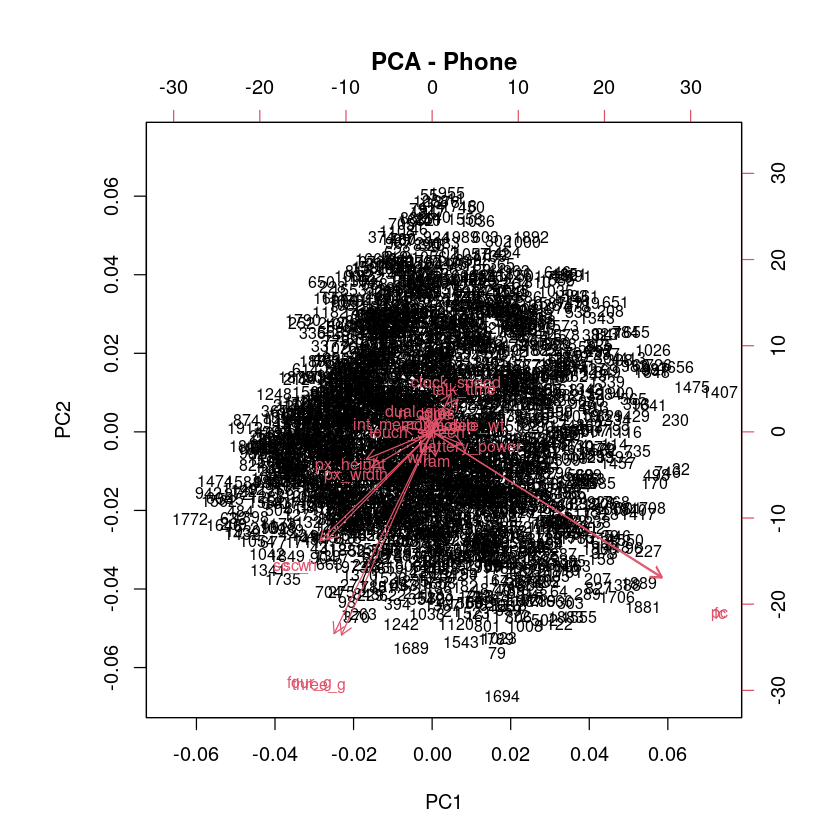

In [257]:
data.phone.pca = prcomp(data.phone.x, scale=TRUE)
biplot(data.phone.pca, cex=0.8, main="PCA - Phone")

De este grafico no podemos sacar mucha informacion, intente hacer que el plot sea un poco mas grande para poder ver mejor los datos, pero no pude. Por lo tanto no puedo sacar conclusiones de este grafico.

Lo que si decidi aplicar 2 metodos que estan a continuacion.

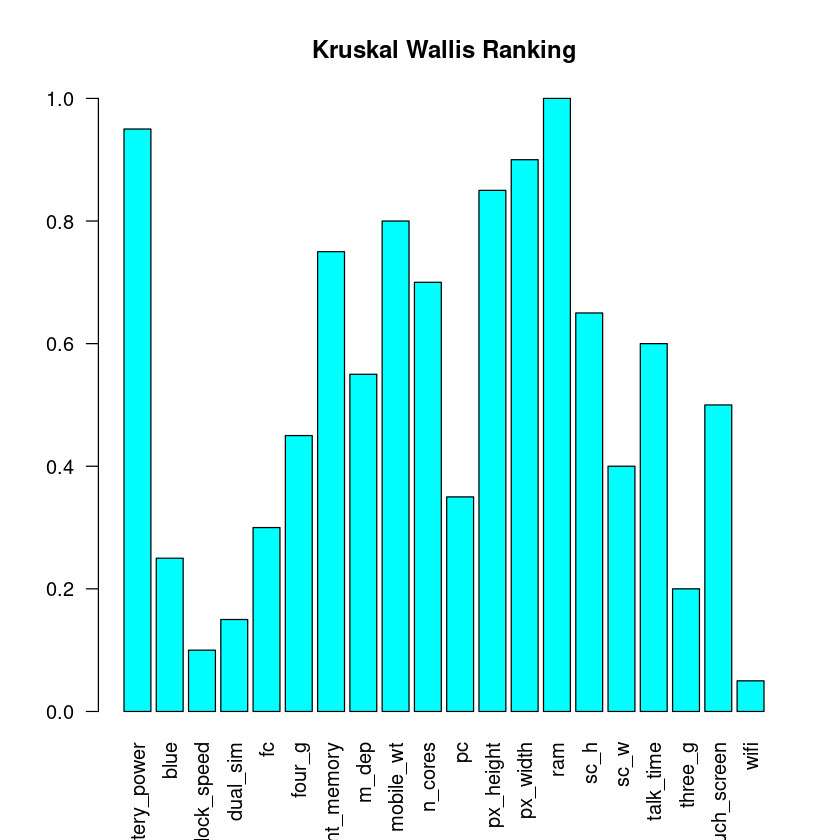

In [258]:
rank.list = kruskal_wallis.ranking(data.phone.x, data.phone.y)
plotbar_values(rank.list, "Kruskal Wallis Ranking")

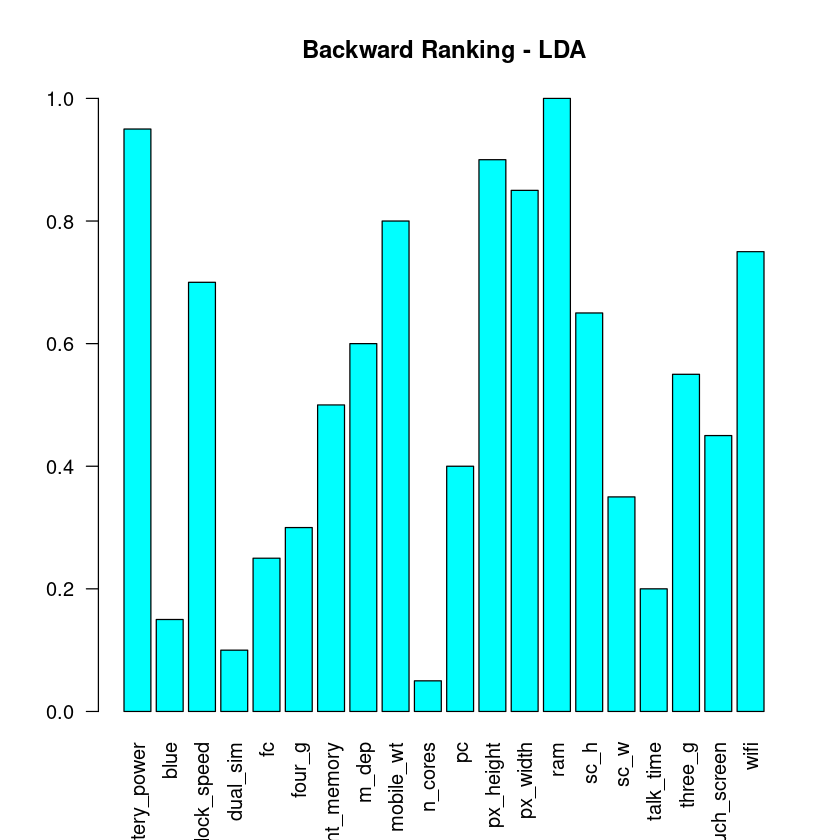

In [262]:
rank.list = backward.ranking(data.phone.x, data.phone.y, method="lda.est")
plotbar_values(rank.list, "Backward Ranking - LDA")

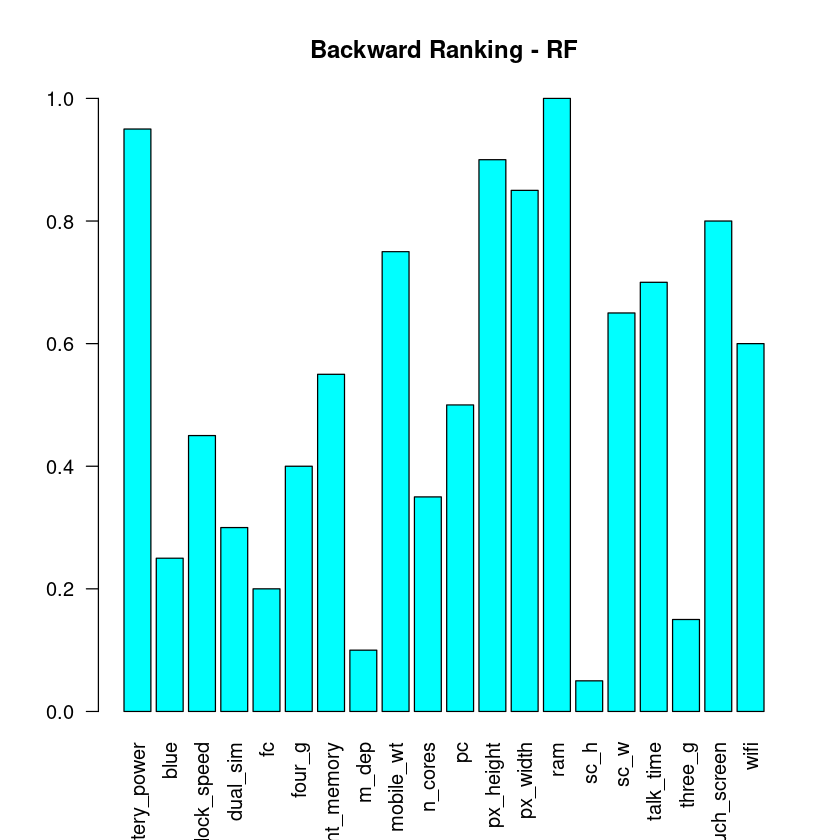

In [263]:
rank.list = backward.ranking(data.phone.x, data.phone.y, method="rf.est")
plotbar_values(rank.list, "Backward Ranking - RF")

Como podemos ver, las features como cantidad de RAM o la bateria (duracion) son variables que claramente impactan en el precio de los celulares y por lo tanto, son las features que salieron con mejor rank.

Tambien podemos ver que hoy en dia, los celulares vienen con camara de fotos y podemos ver como las variables px_height y px_width con alto valores de rank ya que implica un costo mayor en el celular porque hay que poner mejores lentes. Por otro lado se puede ver que por ejemplo la feature wifi, no tiene un alto rank, ya que hoy en dia casi todos los celulares tienen wifi. Tambien se puede ver como dual_sim no tiene un alto rank, ya que es algo que bastante comun y no es algo que impacte en el precio del celular.